In [128]:
using Plots, JLD, Base.Filesystem, OffsetArrays, LaTeXStrings, StatPlots, Printf
import OffsetArrays: no_offset_view

## Visualize results

In [3]:
plot_size = (1200, 400)

(1200, 400)

In [194]:
by_spokes = Dict()
by_noise = Dict()
for (root, dirs, files) in walkdir("fourth_trial")
    for file in files
        if endswith(file, ".jld")
            path = joinpath(root, file)
            d = load(path)
            
            if d["SNR_dB"] == Inf && d["line"] > 2
                
                by_spokes[d["line"]] = Dict{String, Float64}(
                    "ZF" => d["cost_pogm"][0],
                    "IRLS" => d["cost_irls"][end],
                    "POGM" => d["cost_pogm"][end],
                    "MSLR" => d["cost_mslr"][end])
            end
            
            if d["line"] == 24 && d["SNR_dB"] != 20 && d["SNR_dB"] != 160
                logdet = d["cost_irls"][end]
                mslr = d["cost_mslr"][end]
                SNR = d["SNR_dB"] == Inf ? Inf : Int(d["SNR_dB"])
                by_noise[SNR] = Dict{String, Float64}(
                    "ZF" => d["cost_pogm"][0],
                    "IRLS" => logdet  == -1 ? 0 : logdet,
                    "POGM" => d["cost_pogm"][end],
                    "MSLR" => mslr < d["cost_mslr"][0] ? mslr : 0)
            end
        end
    end
end

In [195]:
spokes = string.(sort(collect(keys(by_spokes)), by=x->x[1], rev=true))
spokes = [length(s) == 1 ? " "*s : s for s in spokes]
spokes = string.(repeat(spokes, inner=4));

In [196]:
names, MSE = Vector{Float64}(undef, 0), Vector{String}(undef, 0)
for pair in sort(collect(by_spokes), by=x->x[1], rev=true)
    names = string.(vcat(names, collect(keys(pair[2]))))
    MSE = Float64.(vcat(MSE, collect(values(pair[2]))))
end
typeof(names), typeof(MSE), typeof(spokes)

(Array{String,1}, Array{Float64,1}, Array{String,1})

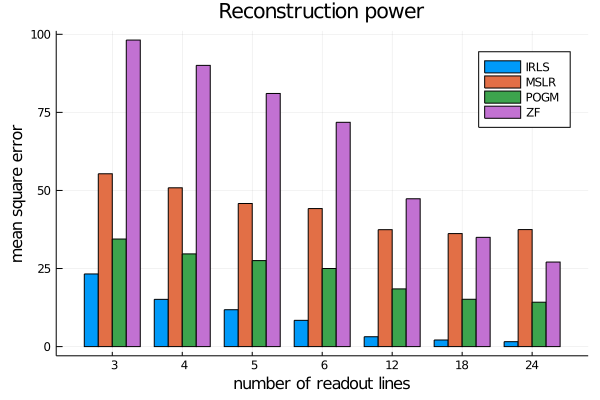

In [197]:
groupedbar(spokes, MSE, group = names, xlabel = "number of readout lines",
    ylabel = "mean square error", title = "Reconstruction power")

Parameters: $rank(L_{true}) = 8$, $\Vert S\_{true} \Vert_0 = 1206$, no noise added

In [198]:
SNR = sort(collect(keys(by_noise)), by=x->x[1], rev=true)
SNR = [@sprintf("%3u", s) for s in SNR]
SNR = string.(repeat(SNR, inner=4));

In [199]:
names, MSE = Vector{Float64}(undef, 0), Vector{String}(undef, 0)
for pair in sort(collect(by_noise), by=x->x[1], rev=true)
    names = string.(vcat(names, collect(keys(pair[2]))))
    MSE = Float64.(vcat(MSE, collect(values(pair[2]))))
end
typeof(names), typeof(MSE), typeof(spokes)

(Array{String,1}, Array{Float64,1}, Array{String,1})

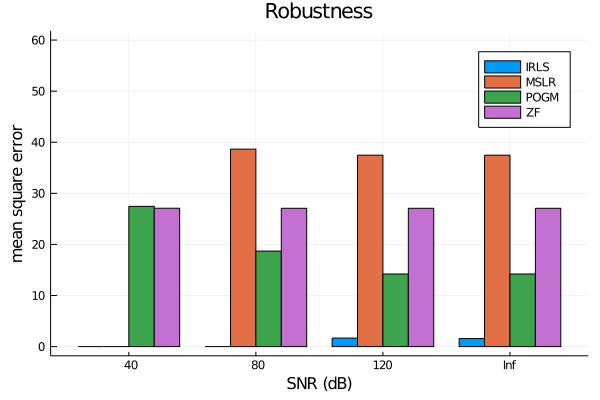

In [200]:
groupedbar(SNR, MSE, group = names, xlabel = "SNR (dB)", ylimit = [0, 60],
    ylabel = "mean square error", title = "Robustness")

Parameters: $\text{#  of spokes} = 24$, $rank(L_{true}) = 8$, $\Vert S_{true} \Vert_0 = 1206$

*Note that missing columns mean that the given algorithm  diverged at that noise level. "Inf" refers to the noiseless case.*

### Plot against time

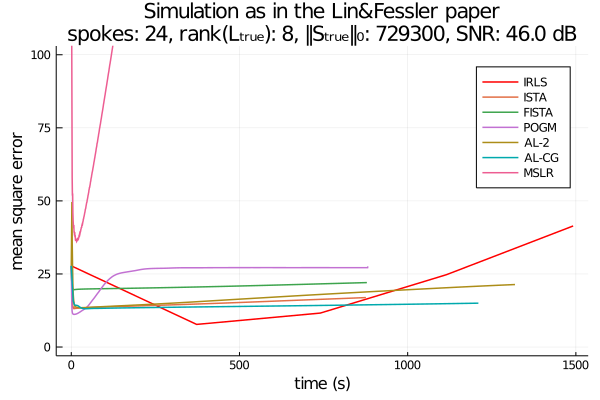

In [177]:
d = load("second_trial/l24_r8_s0_46.jld")

cost_irls = d["cost_irls"]
time_irls = d["time_irls"]
ff₁ = findfirst(cost_irls .> cost_irls[0])
if !(ff₁ isa Nothing)
    cost_irls = cost_irls[0:ff₁]
    time_irls = time_irls[0:ff₁]
else
    cost_irls = cost_irls[0:end]
    time_irls = time_irls[0:end]
end

noise = d["SNR_dB"] < Inf ? "SNR: " * string(d["SNR_dB"]) * " dB" : "noiseless"
p_cost = plot(time_irls, cost_irls, label="IRLS",
    linewidth = 1.5, linecolor = :red, ylimit = [0, 100],
    title = """Simulation as in the Lin&Fessler paper\nspokes: $(d["line"]), rank(Lₜᵣᵤₑ): $(d["target_rank"]), ‖Sₜᵣᵤₑ‖₀: $(d["s"]), $noise""",
    xlabel = "time (s)", ylabel = "mean square error")

plot!(d["time_ista"], d["cost_ista"], label="ISTA", linewidth = 1.5)
plot!(d["time_fista"], d["cost_fista"], label="FISTA", linewidth = 1.5)
plot!(d["time_pogm"], d["cost_pogm"], label="POGM", linewidth = 1.5)
plot!(d["time_al"], d["cost_al"], label="AL-2", linewidth = 1.5)
plot!(d["time_cg"], d["cost_cg"], label="AL-CG", linewidth = 1.5)

cost_mslr = d["cost_mslr"]
time_mslr = d["time_mslr"]
plot!(time_mslr, cost_mslr, label="MSLR", linewidth = 1.5)

*IRLS and MSLR diverges, others converges to the minimizer of "‖⋅‖ₙ + ‖⋅‖₀" problem.*

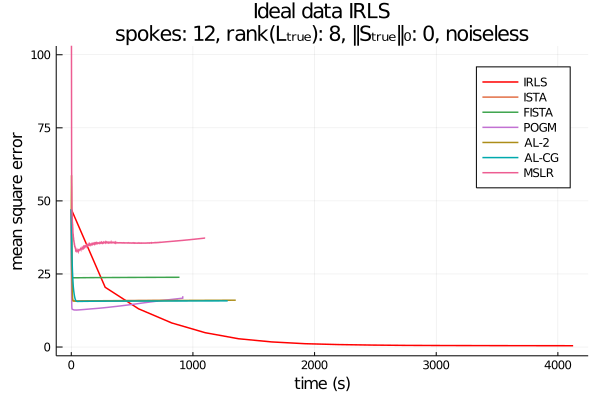

In [178]:
d = load("second_trial/l12_r8_s10_Inf.jld")

cost_irls = d["cost_irls"]
time_irls = d["time_irls"]
ff₁ = findfirst(cost_irls .> cost_irls[0])
if !(ff₁ isa Nothing)
    cost_irls = cost_irls[0:ff₁]
    time_irls = time_irls[0:ff₁]
else
    cost_irls = cost_irls[0:end]
    time_irls = time_irls[0:end]
end

noise = d["SNR_dB"] < Inf ? "SNR: " * string(d["SNR_dB"]) * " dB" : "noiseless"
p_cost = plot(time_irls, cost_irls, label="IRLS",
    linewidth = 1.5, linecolor = :red, ylimit = [0, 100],
    title = """Ideal data IRLS\nspokes: $(d["line"]), rank(Lₜᵣᵤₑ): $(d["target_rank"]), ‖Sₜᵣᵤₑ‖₀: $(d["s"]), $noise""",
    xlabel = "time (s)", ylabel = "mean square error")

plot!(d["time_ista"], d["cost_ista"], label="ISTA", linewidth = 1.5)
plot!(d["time_fista"], d["cost_fista"], label="FISTA", linewidth = 1.5)
plot!(d["time_pogm"], d["cost_pogm"], label="POGM", linewidth = 1.5)
plot!(d["time_al"], d["cost_al"], label="AL-2", linewidth = 1.5)
plot!(d["time_cg"], d["cost_cg"], label="AL-CG", linewidth = 1.5)

cost_mslr = d["cost_mslr"]
time_mslr = d["time_mslr"]
plot!(time_mslr, cost_mslr, label="MSLR", linewidth = 1.5)

*All algorithms converges, with IRLS reaching near perfect reconstruction.*

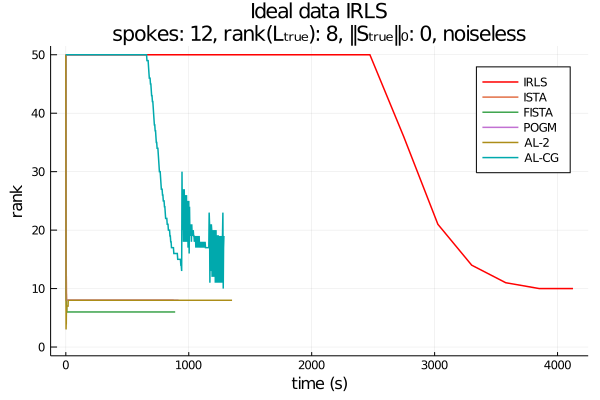

In [179]:
rankL_irls = d["rankL_irls"]
time_irls = d["time_irls"]
ff₁ = findfirst(rankL_irls .> rankL_irls[0])
if !(ff₁ isa Nothing)
    rankL_irls = rankL_irls[0:ff₁]
    time_irls = time_irls[0:ff₁]
else
    rankL_irls = rankL_irls[0:end]
    time_irls = time_irls[0:end]
end

noise = d["SNR_dB"] < Inf ? "SNR: " * string(d["SNR_dB"]) * " dB" : "noiseless"
plot(time_irls, rankL_irls, label="IRLS",
    linewidth = 1.5, linecolor = :red, ylimit = [0, 50],
    title = """Ideal data IRLS\nspokes: $(d["line"]), rank(Lₜᵣᵤₑ): $(d["target_rank"]), ‖Sₜᵣᵤₑ‖₀: $(d["s"]), $noise""",
    xlabel = "time (s)", ylabel = "rank")

plot!(d["time_ista"], d["rankL_ista"], label="ISTA", linewidth = 1.5)
plot!(d["time_fista"], d["rankL_fista"], label="FISTA", linewidth = 1.5)
plot!(d["time_pogm"], d["rankL_pogm"], label="POGM", linewidth = 1.5)
plot!(d["time_al"], d["rankL_al"], label="AL-2", linewidth = 1.5)
plot!(d["time_cg"], d["rankL_cg"], label="AL-CG", linewidth = 1.5)

In [37]:
L"\Vert X_{true} - X_\infty \Vert_F"

L"$\Vert X_{true} - X_\infty \Vert_F$"